In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,15)

# Question 2

In [2]:
dataset = []
labels = []
image_shape = None
for folder_index in range(1, 40 + 1):
    for file_index in range(1, 10+1):
        file_name = f'archive/s{folder_index}/{file_index}.pgm'
        image = cv2.imread(file_name, -1).astype(np.float32)
        image_shape = image.shape
        dataset.append(image.reshape(-1))
        labels.append(folder_index - 1)
dataset = np.array(dataset)
labels = np.array(labels)


def train_test_split(X, y):
    return X[::2, :], y[::2], X[1::2, :], y[1::2]

X_train, y_train, X_test, y_test = train_test_split(dataset, labels)

In [3]:
class NaiveBayesClf:
    def __init__(self, dataset, labels):
        self.X = [dataset[labels == label] for label in np.unique(labels)]
        dataset_size = len(dataset)
        self.means = [np.mean(subset, axis=0) for subset in self.X]
        self.log_priors = np.array([-np.log(len(subset) / dataset_size) for subset in self.X])
        self.vars = np.array([np.var(subset, axis=0) for subset in self.X])
    
    def predict(self, x):
        eps = np.finfo(np.float32).eps
        probs = []
        for m, v in zip(self.means, self.vars):
            v += eps
            pdfs = np.exp(-(x - m)**2 / (2 * v) ) / np.sqrt(2*np.pi * v) + eps
            p = -np.log(pdfs).sum()
            probs.append(p)
        probs = np.array(probs)
        probs += self.log_priors
        return probs.argmin()

In [4]:
clf = NaiveBayesClf(X_train, y_train)
# data_to_be_predicted = dataset.reshape(-1, dataset.shape[-1])
predictions = [clf.predict(img) for img in X_test]

Classification Accuracy = 93.5%


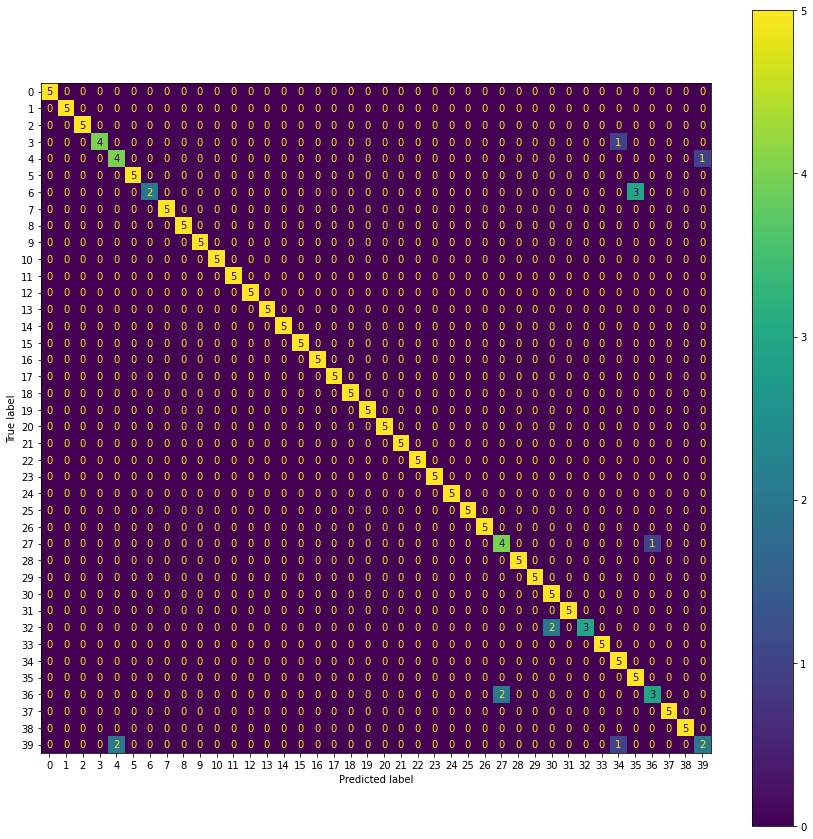

In [5]:
from sklearn.metrics import *
acc = accuracy_score(y_test, predictions)
print(f'Classification Accuracy = {acc*100}%')
mat = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(mat, display_labels=np.arange(40))
disp.plot()

17


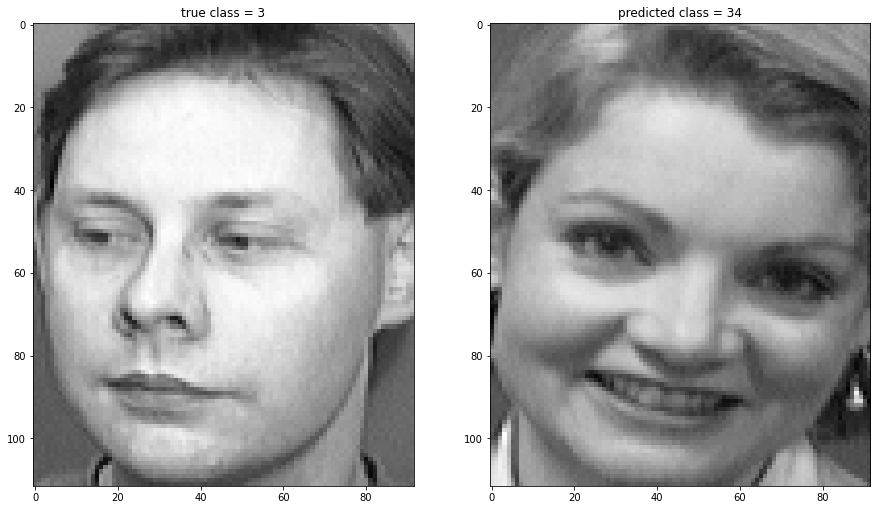

In [20]:
missclassification = np.where(y_test != predictions)[0][0]
print(missclassification)
plt.subplot(121)
plt.title(f'true class = {y_test[missclassification]}')
plt.imshow(X_test[missclassification].reshape(image_shape), cmap='gray')
plt.subplot(122)
plt.title(f'predicted class = {predictions[missclassification]}')
plt.imshow(X_test[predictions[missclassification] * 5].reshape(image_shape), cmap='gray')
plt.show()

In [6]:
class MyPCA:
    def __init__(self, alpha=None, rank=None):
        self.alpha = alpha
        self.rank = rank

    def fit(self, X):
        self.U, self.mu = self._implementation(X, self.alpha, self.rank)
        
    def fit_transform(self, X):
        self.U, self.mu = self._implementation(X, self.alpha, self.rank)
        centered = X - self.mu
        return centered @ self.U

    def predict(self, X):
        centered = X - self.mu
        return centered @ self.U
        
    def _implementation(self, X, alpha, rank=None):
        mu = np.mean(X, axis=0)
        Z = X - mu
        cov_mat = Z.T @ Z / Z.shape[0]
        eig_vals, eig_vecs = np.linalg.eigh(cov_mat)

        eig_vals_cumsum = np.cumsum(eig_vals[::-1]) / np.sum(eig_vals)
        if rank is None:
            rank = np.where(eig_vals_cumsum >= alpha)[0][0] + 1
        return eig_vecs[:, :-(rank + 1):-1], mu

In [7]:
dim_red = MyPCA(rank=40)
reduced_train = dim_red.fit_transform(X_train)
reduced_test = dim_red.predict(X_test)

Classification Accuracy = 87.5%


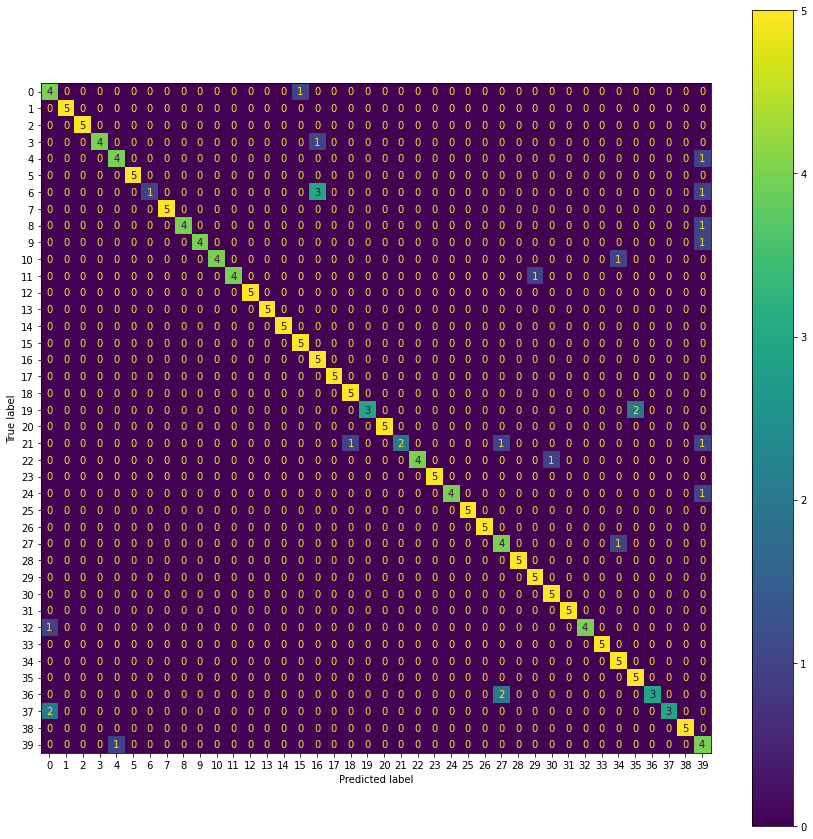

In [8]:
clf = NaiveBayesClf(reduced_train, y_train)
predictions_reduced = np.array([clf.predict(img) for img in reduced_test])
acc_reduced = accuracy_score(y_test, predictions_reduced)
print(f'Classification Accuracy = {acc_reduced * 100}%')
mat = confusion_matrix(y_test, predictions_reduced)
disp = ConfusionMatrixDisplay(mat, display_labels=np.arange(40))
disp.plot()

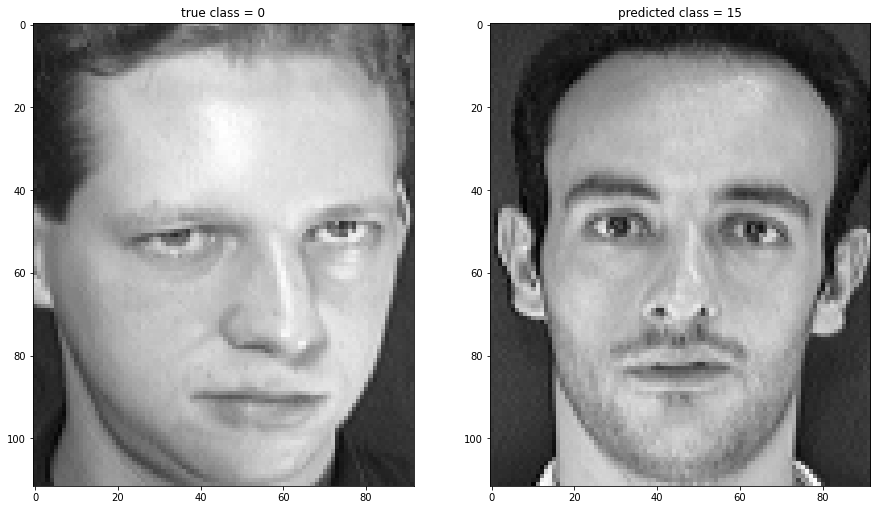

In [21]:
missclassification = np.where(y_test != predictions_reduced)[0][0]
plt.subplot(121)
plt.title(f'true class = {y_test[missclassification]}')
plt.imshow(X_test[missclassification].reshape(image_shape), cmap='gray')
plt.subplot(122)
plt.title(f'predicted class = {predictions_reduced[missclassification]}')
plt.imshow(X_test[predictions_reduced[missclassification] * 5].reshape(image_shape), cmap='gray')
plt.show()

# Question 3

In [22]:
data = np.array([
    [2, 6, 1],
    [6, 6, 1],
    [3, 5, 1],
    [4, 5, 2],
    [5, 5, 2],
    [7, 5, 2],
    [10, 5, 3],
    [13, 5, 3],
    [4, 4, 1],
    [6, 4, 1],
    [7, 4, 2],
    [8, 4, 1],
    [11, 4, 3],
    [3, 3, 2],
    [4, 3, 2],
    [5, 3, 1],
    [7, 3, 2],
    [9, 3, 1],
    [10, 3, 3],
    [11, 3, 3],
    [6, 2, 1],
    [7, 2, 3],
    [9, 2, 1],
    [12, 2, 3],
    [10, 1, 3]
])
X = data[:, :2]
y = data[:, -1] - 1

In [23]:
from scipy.stats import multivariate_normal
class BayesClf:
    def __init__(self, X, y):
        n = len(X)
        dataset = [X[y == label] for label in np.unique(y)]
        class_sizes = [len(subset) for subset in dataset]
        self.log_priors = np.array([-np.log(cnt / n) for cnt in class_sizes])
        self.means = [np.mean(subset, axis=0) for subset in dataset]
        centered_dataset = [subset - mean for subset, mean in zip(dataset, self.means)]
        self.covs = [subset.T @ subset / cnt for subset, cnt in zip(centered_dataset, class_sizes)]
    def predict(self, x):
        log_pdfs = np.array([-multivariate_normal.logpdf(x, mean, cov) for mean, cov in zip(self.means, self.covs)])
        preds = self.log_priors + log_pdfs
        return preds.argmin()


In [24]:
real_labels = ['C1', 'C2', 'C3']

clf = BayesClf(X, y)
new_points = np.array([
    [6, 5],
    [9, 4],
    [8, 5]
])
predictions = [real_labels[clf.predict(point)] for point in new_points]
print(predictions)

['C2', 'C3', 'C2']


In [25]:
def is_in_region(x, region):
    for x_i, r_i in zip(x, region):
        if x_i > r_i:
            return 0
    return 1

def create_new_dataset(X):
    regions_endpoints = np.array([
        [3, 2],
        [6, 4],
        [9, 6]
    ])
    new_dataset = []

    for point in X:
        new_dataset.append([is_in_region(point, r) for r in regions_endpoints])
    new_dataset = np.array(new_dataset)
    return new_dataset

X_new = create_new_dataset(X)
X_new

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 0],
       [0, 0, 0],
       [0, 1, 1],
       [0, 1, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 0],
       [0, 1, 1],
       [0, 1, 1],
       [0, 1, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 0],
       [0, 0, 0],
       [0, 1, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 0],
       [0, 0, 0]])

In [15]:
real_labels = ['C1', 'C2', 'C3']

clf = NaiveBayesClf(X_new, y)
new_points_transformed = create_new_dataset(new_points)
new_predictions = [real_labels[clf.predict(point)] for point in new_points_transformed]
print(new_predictions)

['C1', 'C1', 'C1']
